# patch_size를 1, 3, 5, 7, 9, 11로 바꾸어 가면서 테스트 해 보자

In [2]:
from utils.utils import train_model, evaluate_model_with_cm, TiffDataset
from models.image_classifier import ResNetLike
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
test_filter = lambda box_number: (box_number % 9 == 0 or box_number % 9 == 5)

### 데이터 준비함수, 학습 평가 함수 정의

In [5]:
# 이미지 전처리 (Naive)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # uint16 → float 변환
])

# 데이터셋 생성 함수
def create_datasets(patch_size):
    dataset_kwargs = {
        "large_tif_dir": "../../data/source_data/naive",
        "file_list": ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"],
        "label_file": "../../data/label_data/label_mapping_sampled.csv",
        "patch_size": patch_size,
        "transform": transform
    }
    return (
        TiffDataset(**dataset_kwargs, box_filter_fn=lambda box_number: not test_filter(box_number)),  # train
        TiffDataset(**dataset_kwargs, box_filter_fn=test_filter)  # val
    )

# 데이터로더 생성 함수
def create_dataloaders(train_dataset, val_dataset, batch_size=32, num_workers=0):
    return (
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    )


### 패치사이즈를 바꾸어가며 테스트

1
Training with patch size: 1


Epoch 1/1 - Validation: 100%|██████████| 1163/1163 [00:11<00:00, 105.48it/s]



Epoch [1/1], Train Loss: 0.5381, Train Accuracy: 79.93%, Val Loss: 0.6434, Val Accuracy: 74.43%

train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:34<00:00, 106.97it/s]


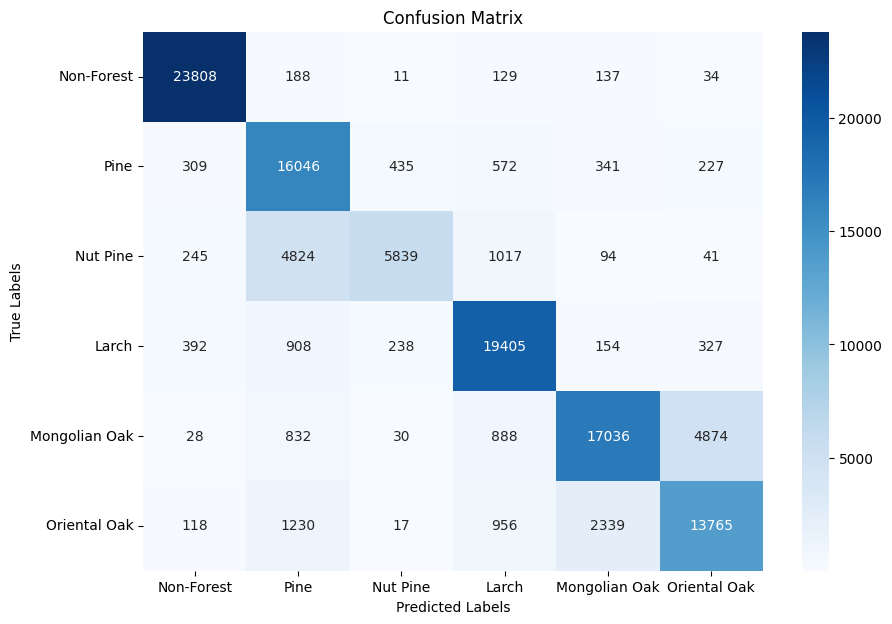

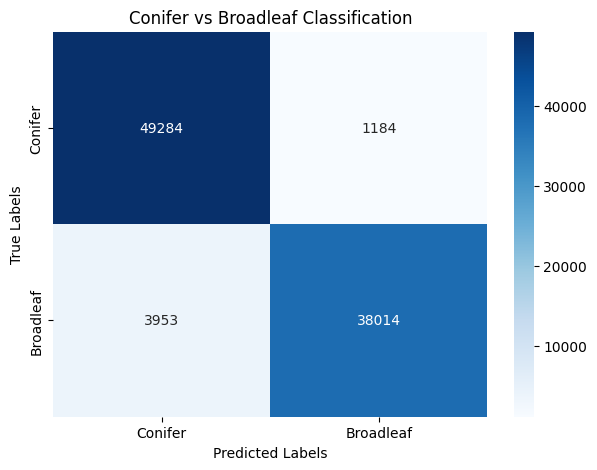

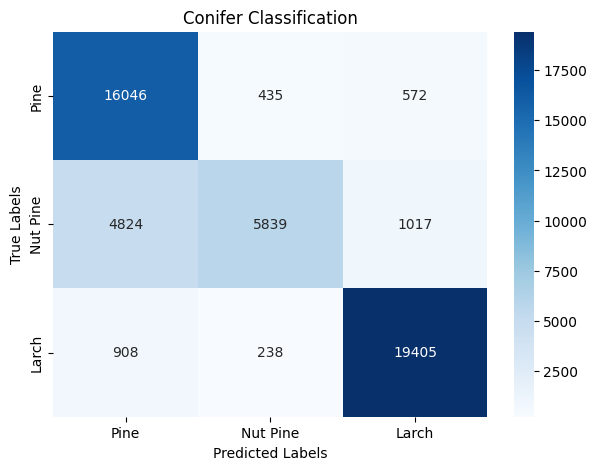

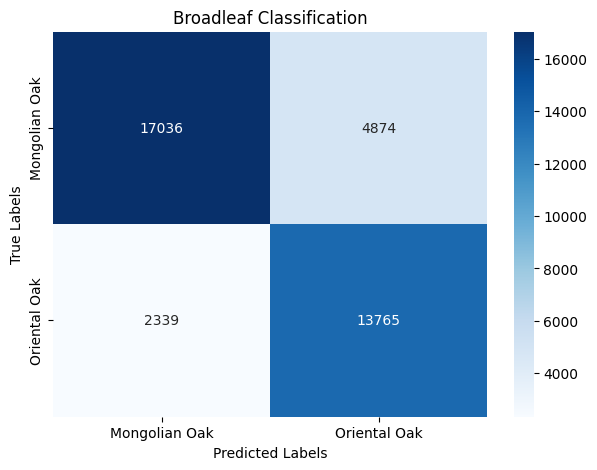

validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:10<00:00, 108.09it/s]


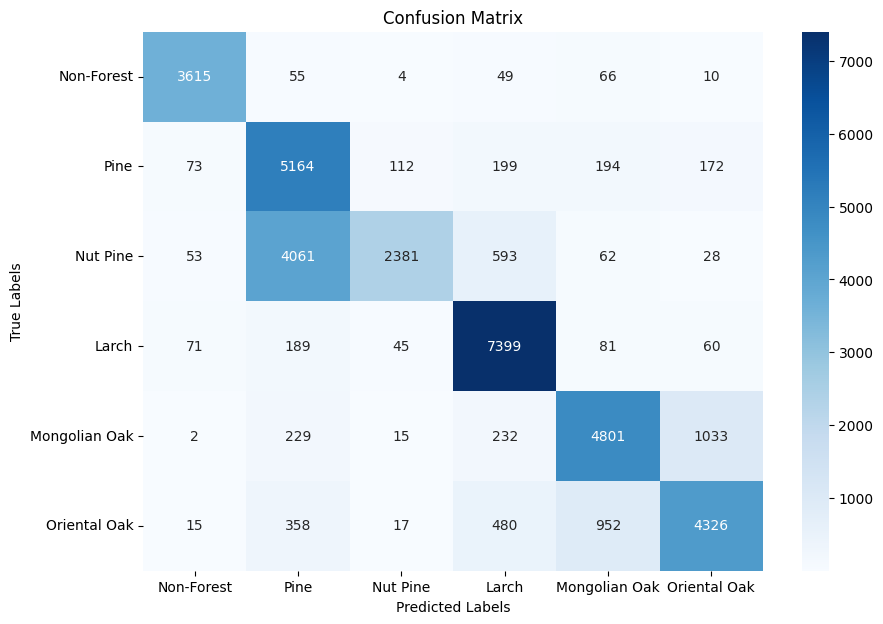

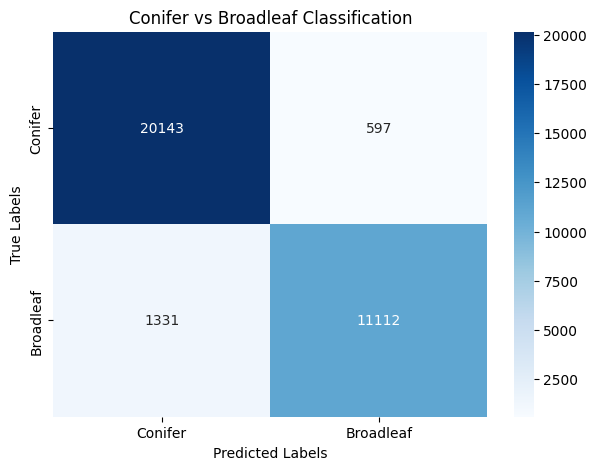

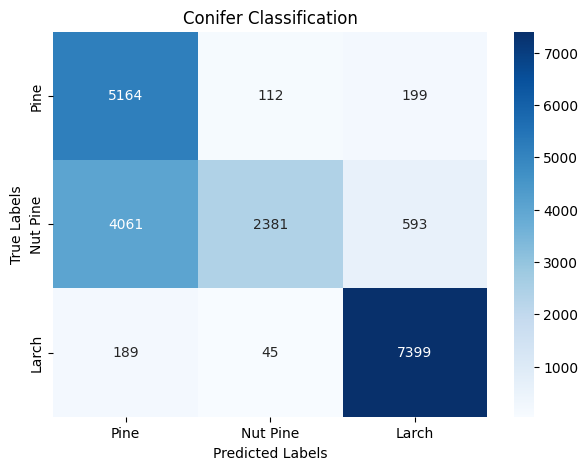

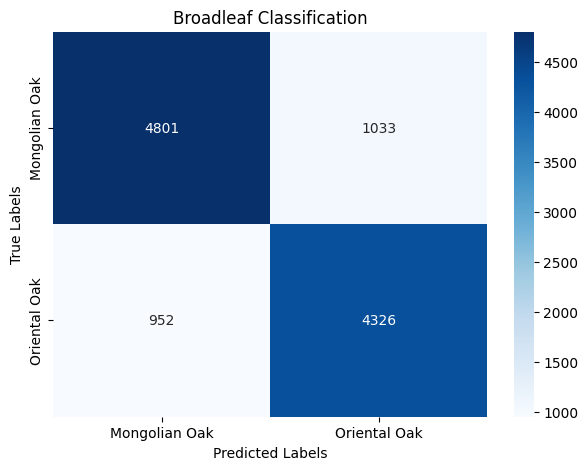

3
Training with patch size: 3


Epoch 1/1 - Validation: 100%|██████████| 1163/1163 [00:14<00:00, 82.11it/s]



Epoch [1/1], Train Loss: 0.5079, Train Accuracy: 81.16%, Val Loss: 0.5055, Val Accuracy: 81.25%

train data


Evaluation Progress: 100%|██████████| 3683/3683 [00:43<00:00, 84.29it/s]


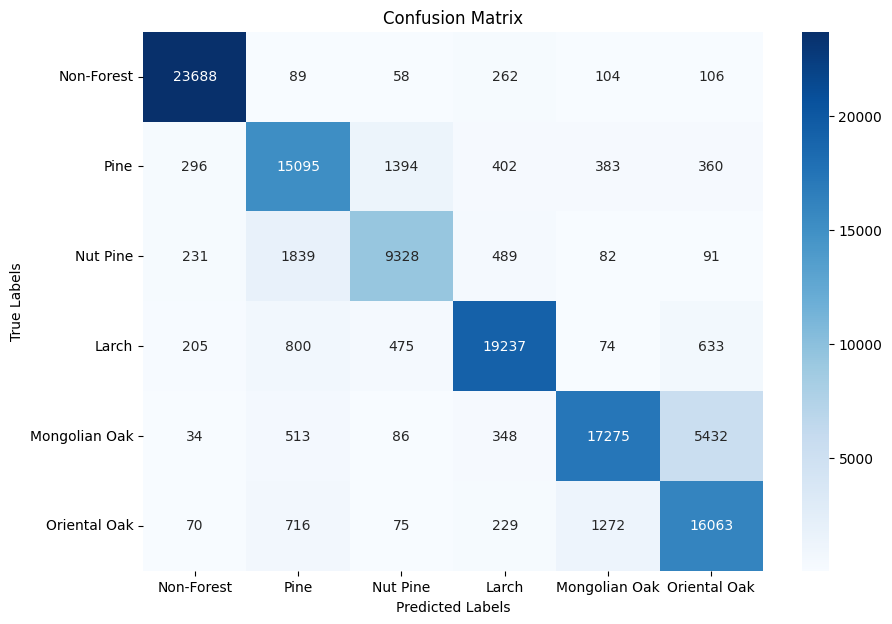

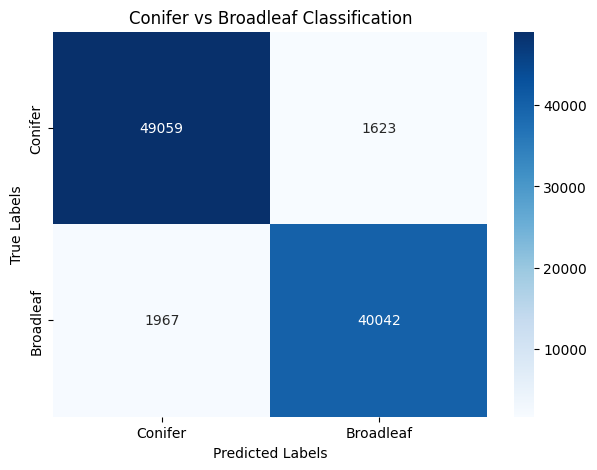

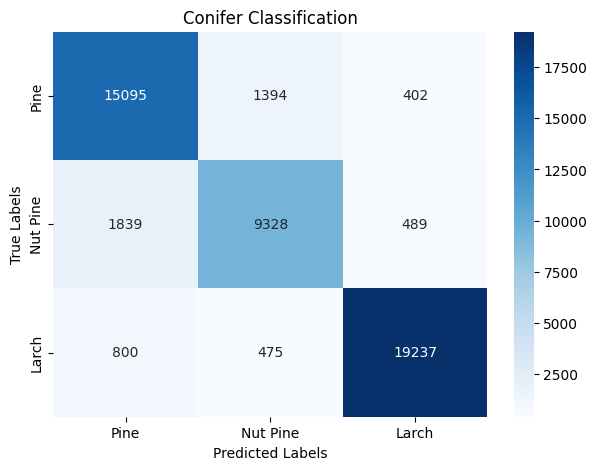

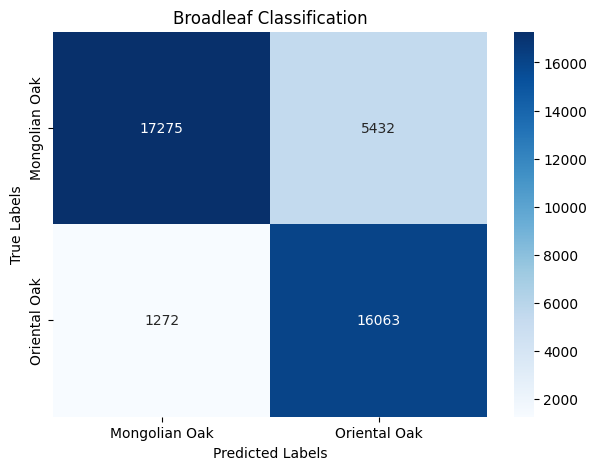

validation data


Evaluation Progress: 100%|██████████| 1163/1163 [00:13<00:00, 83.36it/s]


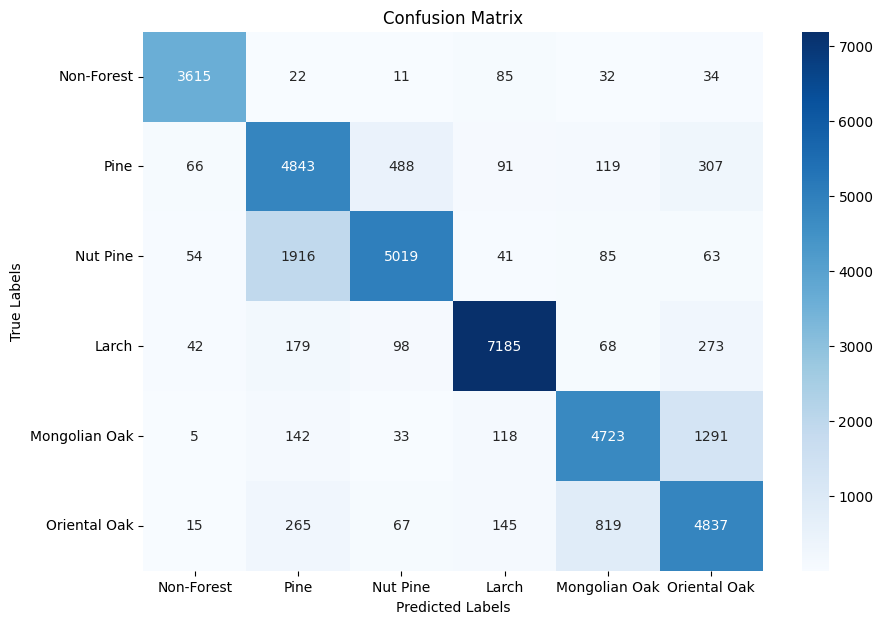

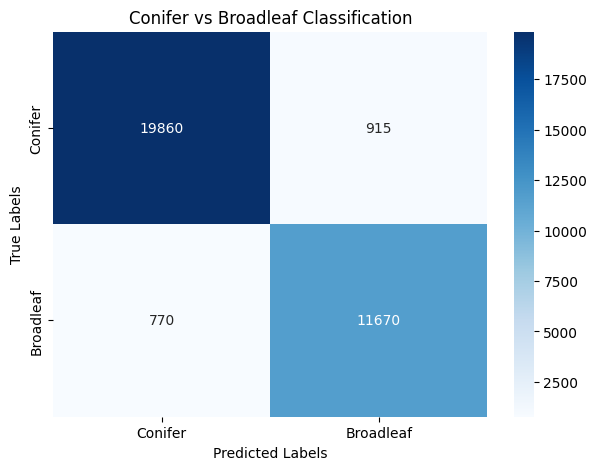

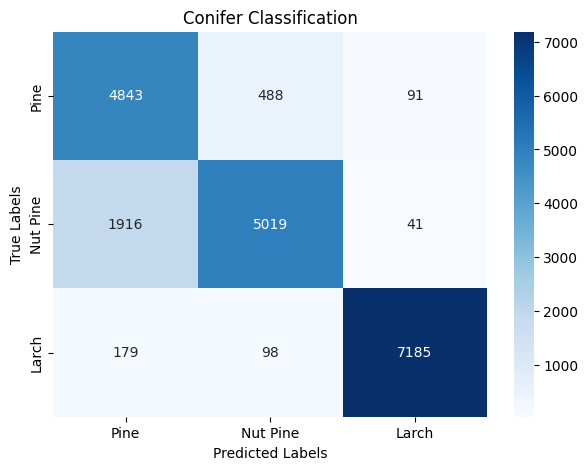

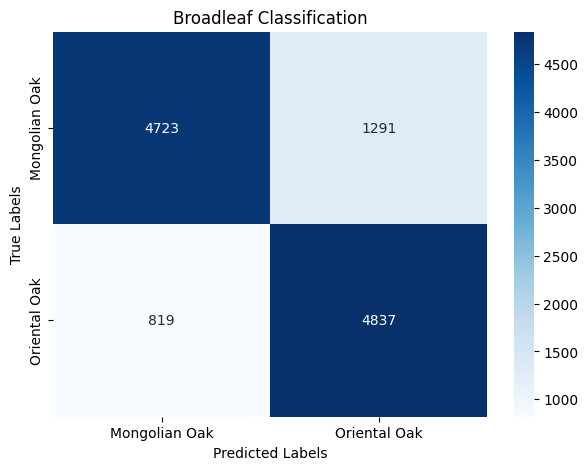

5
Training with patch size: 5


Epoch 1/1 - Validation: 100%|██████████| 1159/1159 [00:18<00:00, 62.92it/s]



Epoch [1/1], Train Loss: 0.4956, Train Accuracy: 81.57%, Val Loss: 0.7259, Val Accuracy: 73.05%

train data


Evaluation Progress: 100%|██████████| 3662/3662 [00:57<00:00, 63.61it/s]


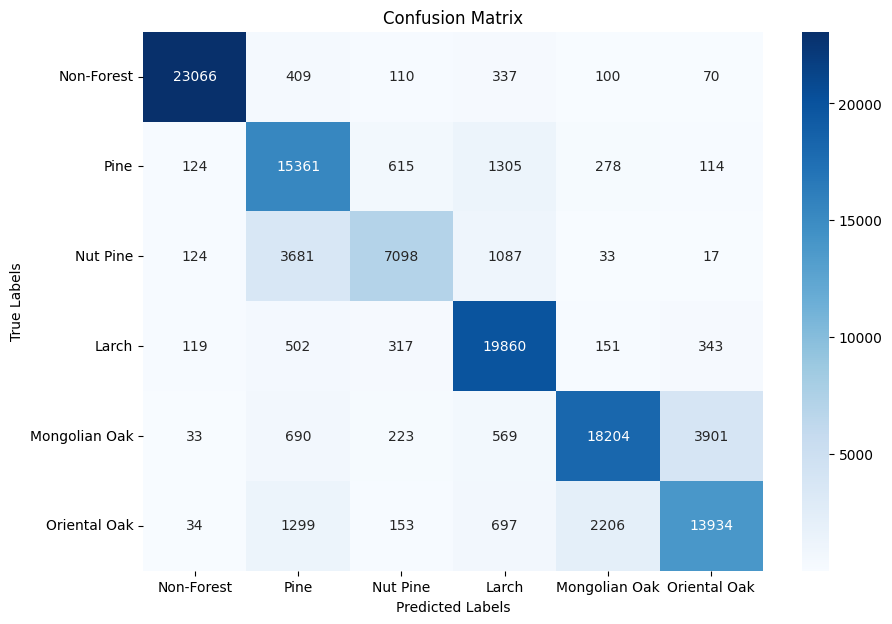

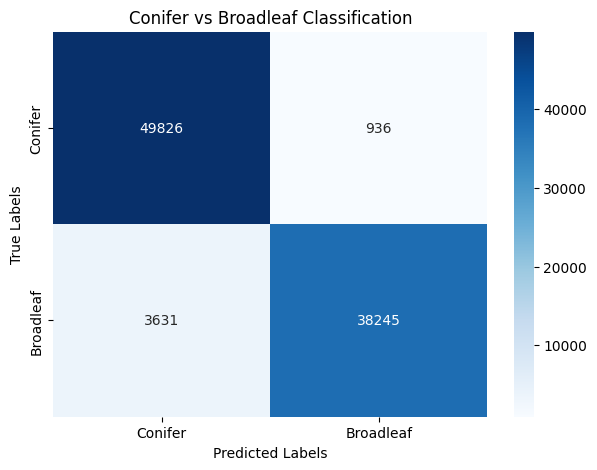

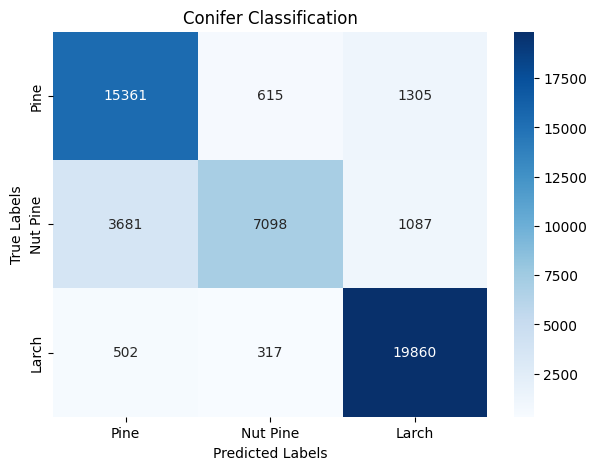

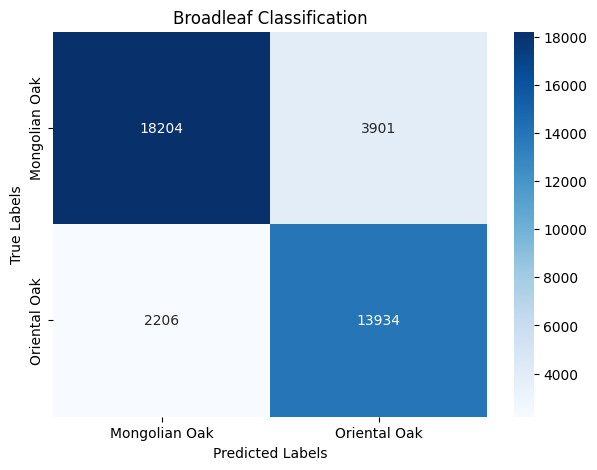

validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:18<00:00, 63.42it/s]


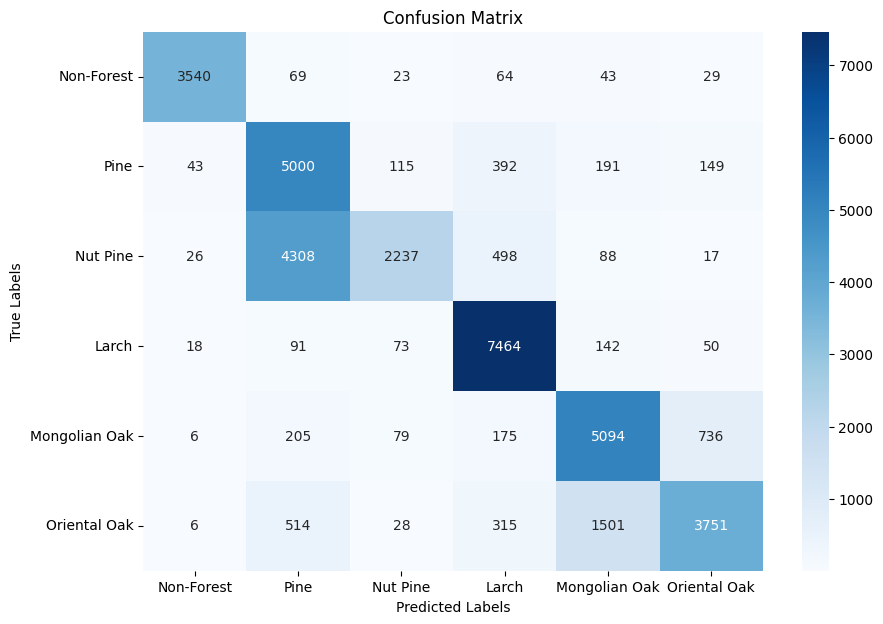

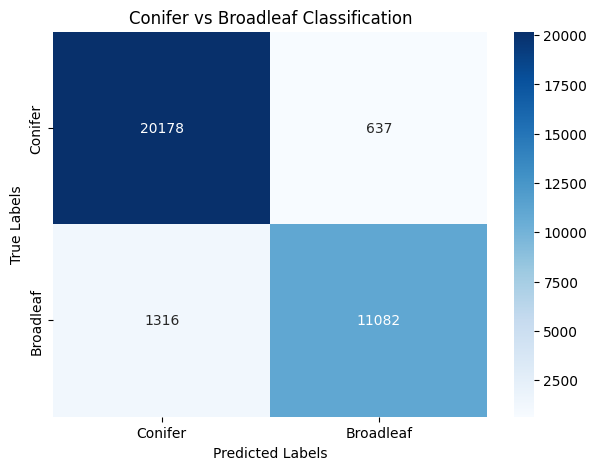

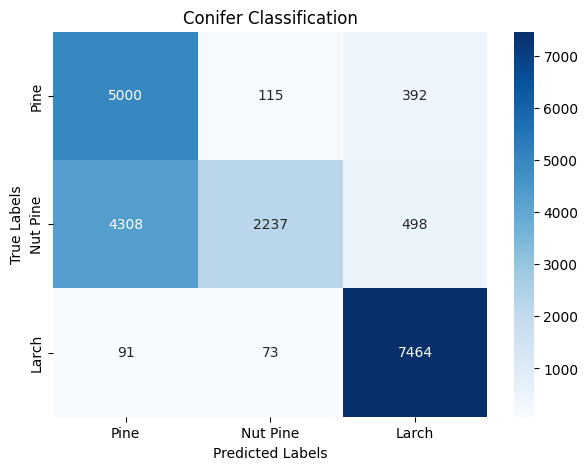

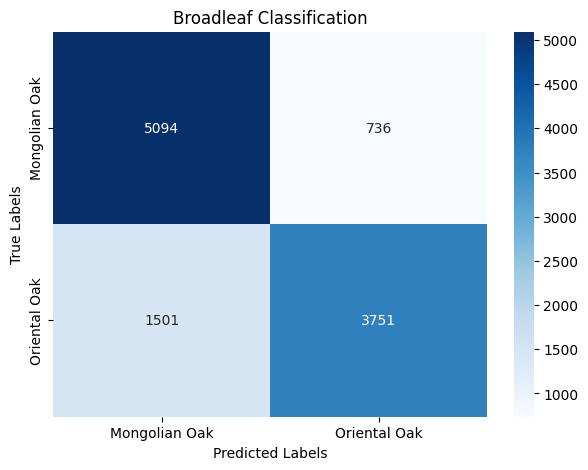

7
Training with patch size: 7


Epoch 1/1 - Validation: 100%|██████████| 1159/1159 [00:25<00:00, 45.06it/s]



Epoch [1/1], Train Loss: 0.4882, Train Accuracy: 81.79%, Val Loss: 0.5269, Val Accuracy: 81.59%

train data


Evaluation Progress: 100%|██████████| 3662/3662 [01:15<00:00, 48.70it/s]


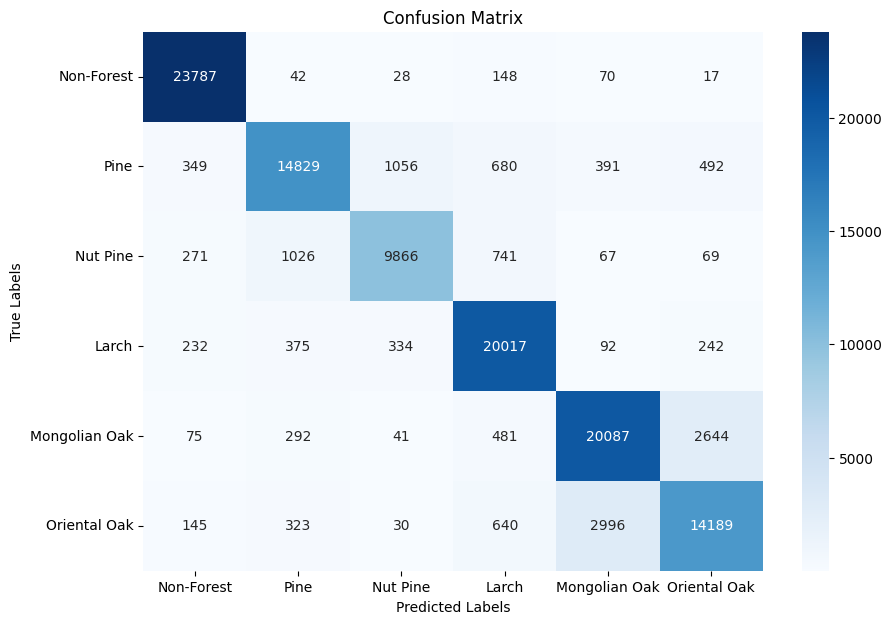

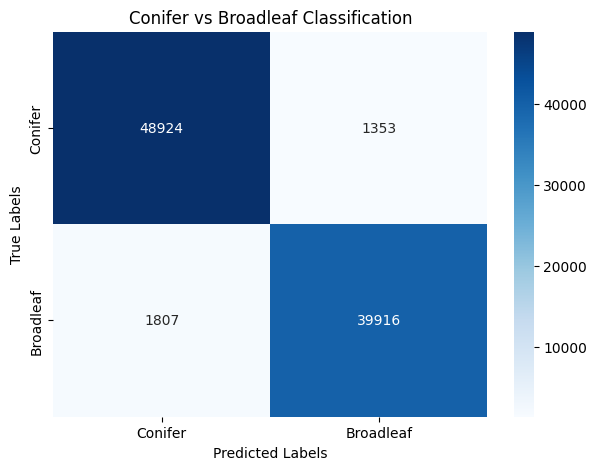

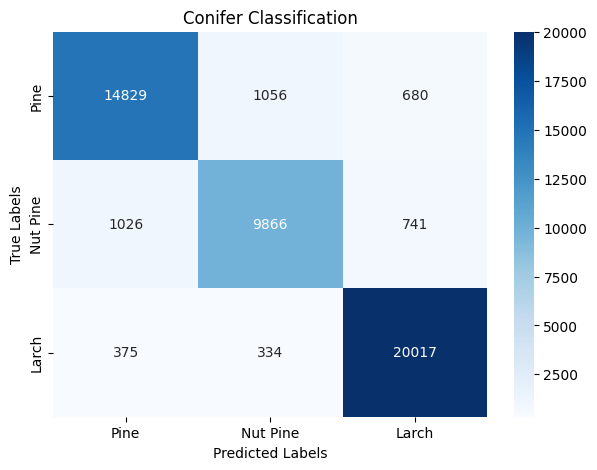

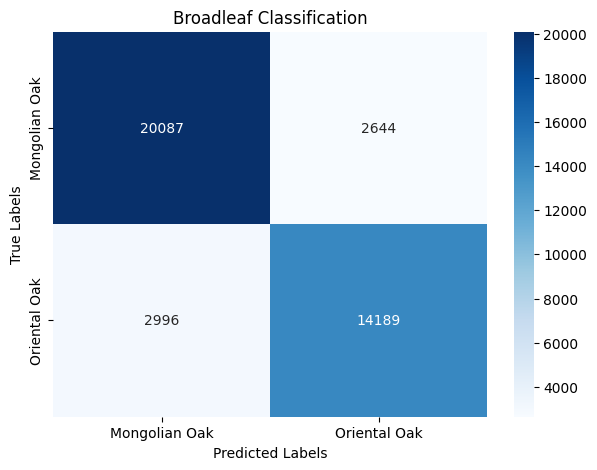

validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:23<00:00, 49.03it/s]


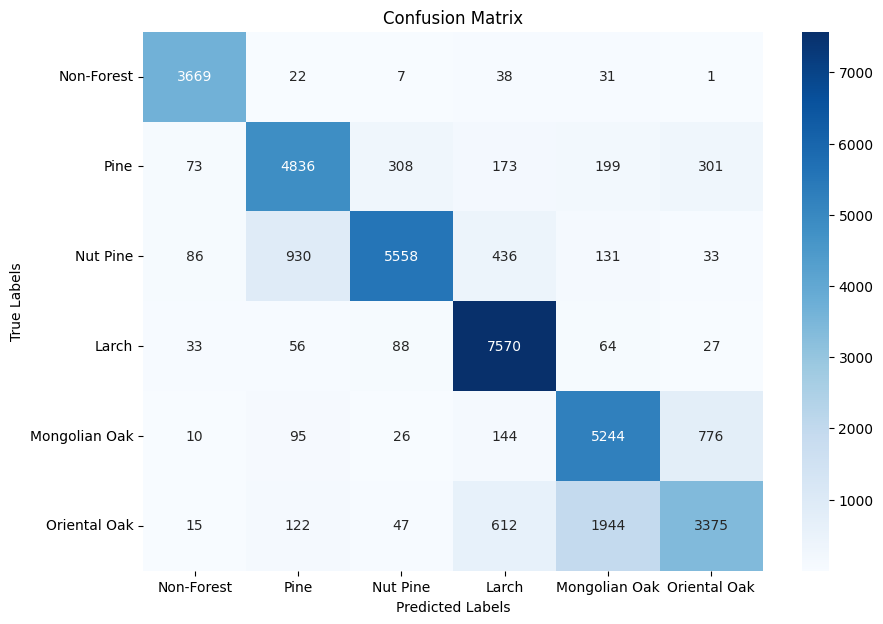

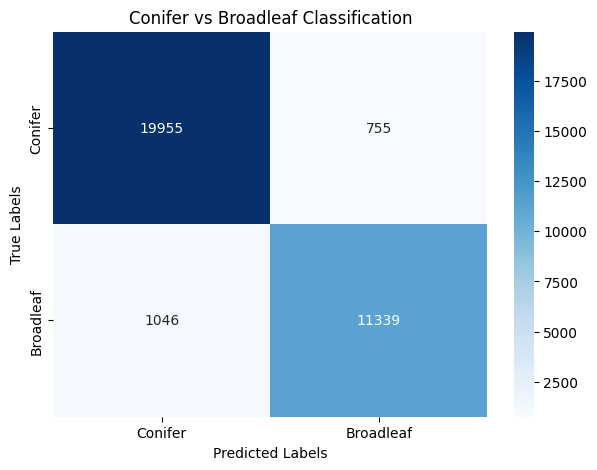

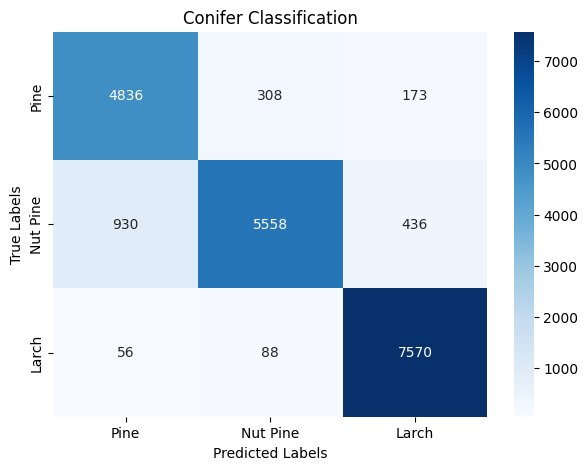

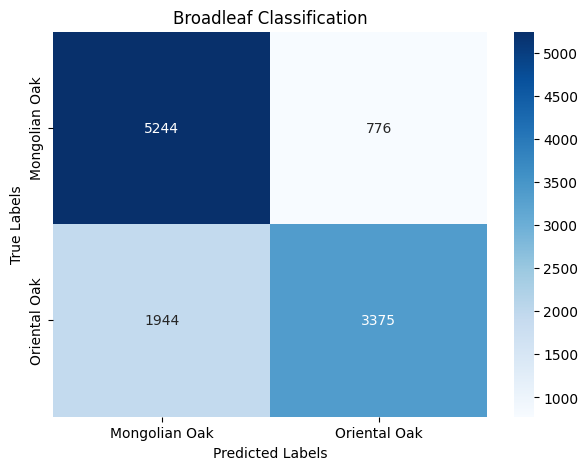

9
Training with patch size: 9


Epoch 1/1 - Validation: 100%|██████████| 1159/1159 [00:31<00:00, 36.57it/s]



Epoch [1/1], Train Loss: 0.4743, Train Accuracy: 82.41%, Val Loss: 0.5797, Val Accuracy: 77.82%

train data


Evaluation Progress: 100%|██████████| 3662/3662 [01:39<00:00, 36.67it/s]


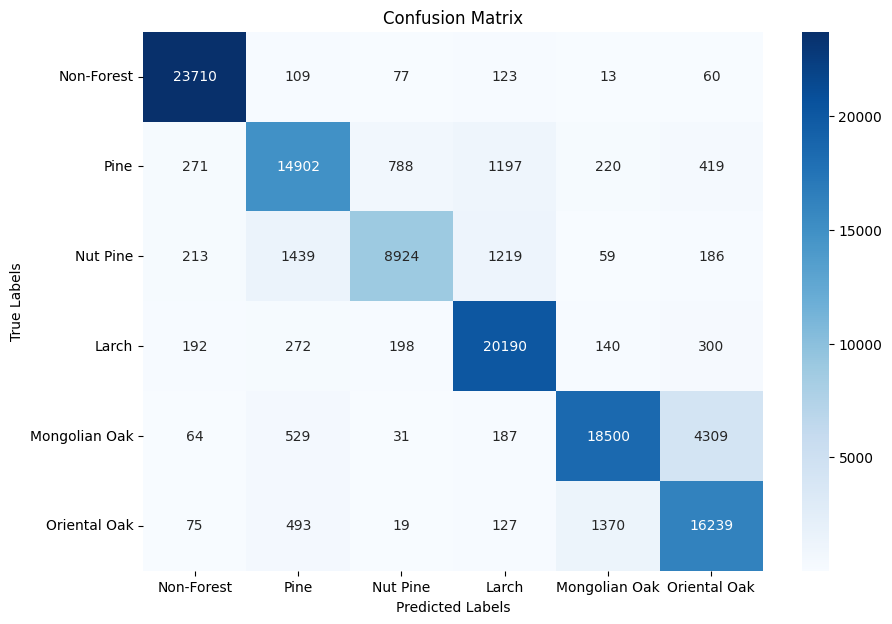

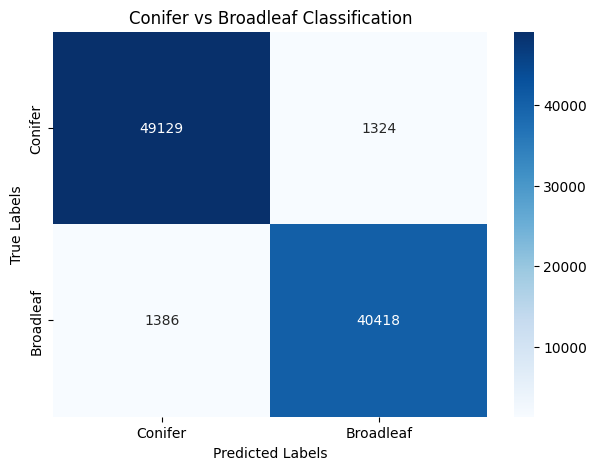

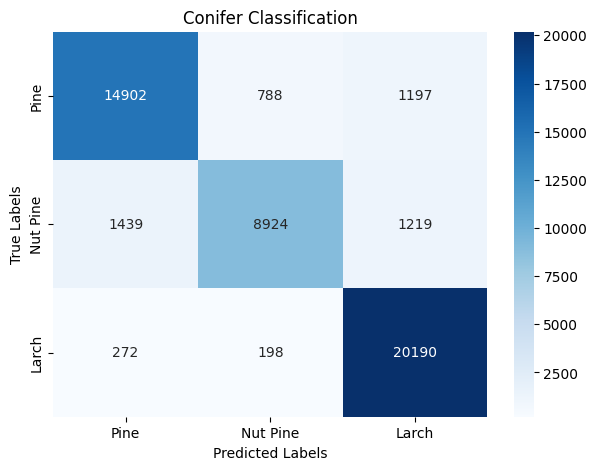

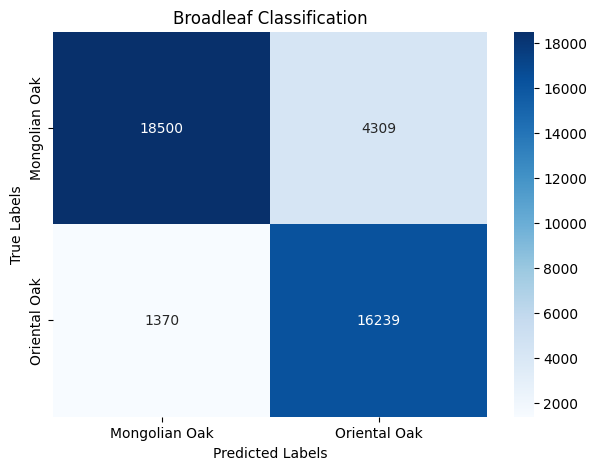

validation data


Evaluation Progress: 100%|██████████| 1159/1159 [00:31<00:00, 36.67it/s]


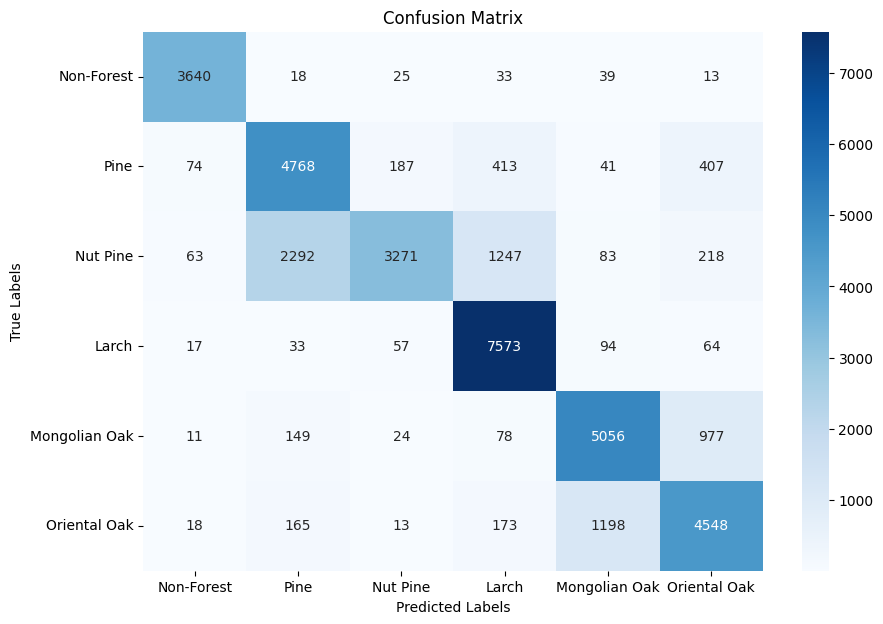

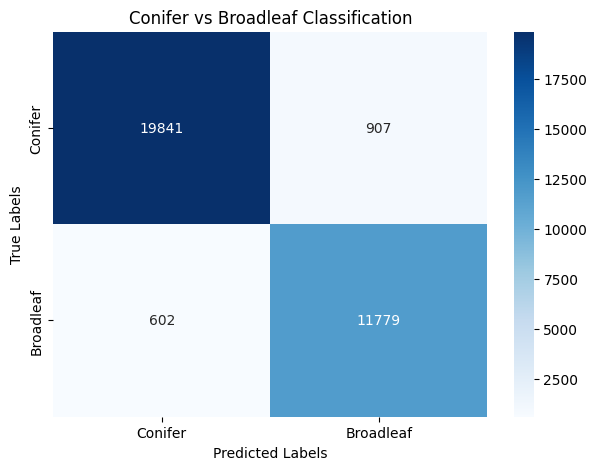

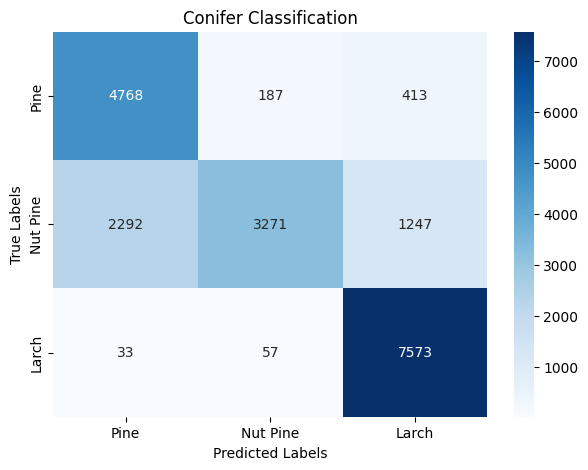

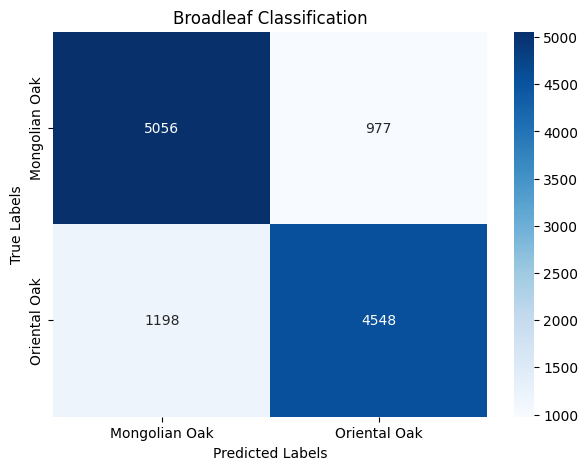

11
Training with patch size: 11


Epoch 1/1 - Validation: 100%|██████████| 1155/1155 [00:41<00:00, 27.86it/s]



Epoch [1/1], Train Loss: 0.4664, Train Accuracy: 82.79%, Val Loss: 0.4566, Val Accuracy: 84.76%

train data


Evaluation Progress: 100%|██████████| 3640/3640 [02:11<00:00, 27.63it/s]


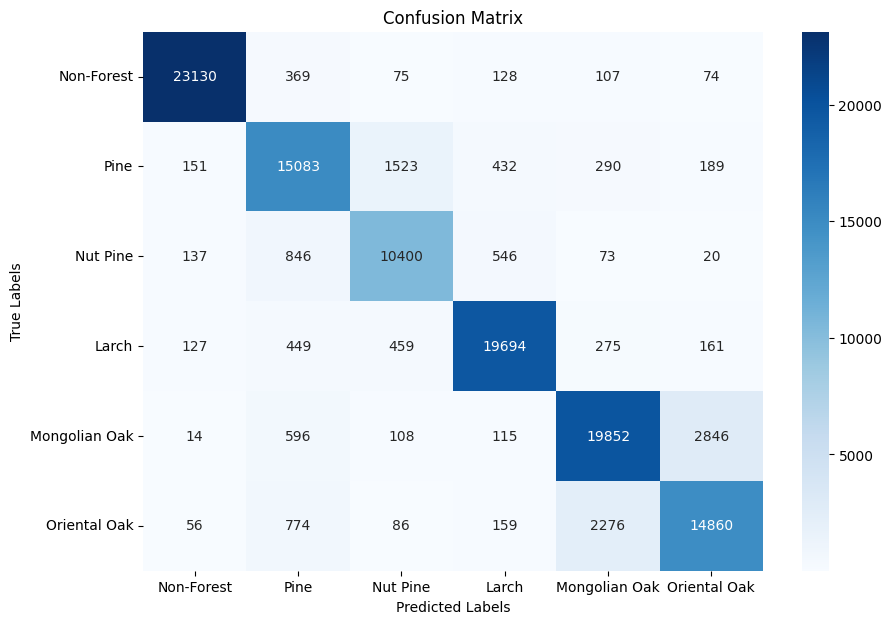

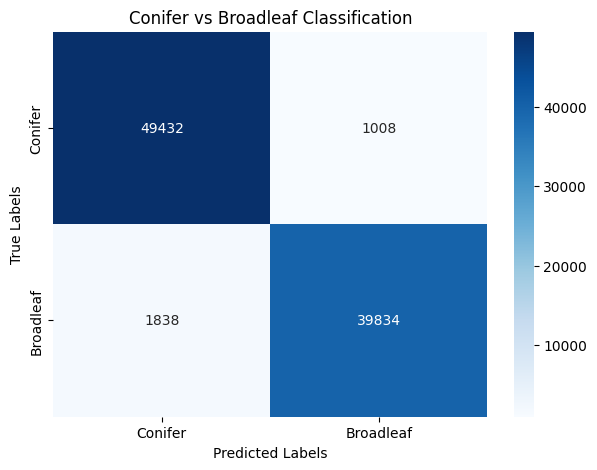

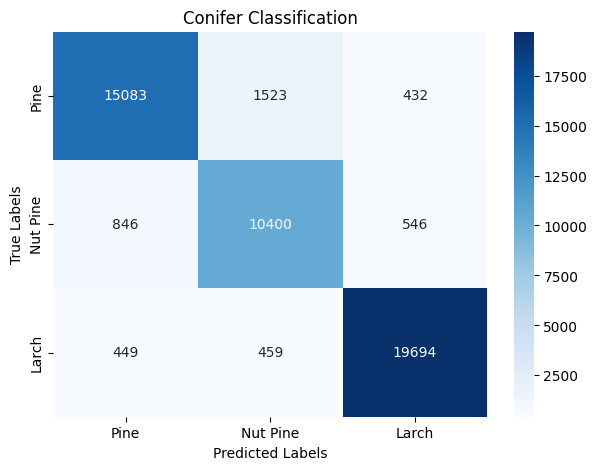

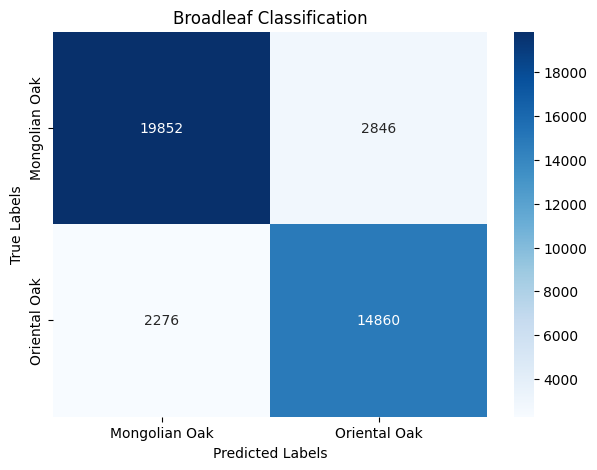

validation data


Evaluation Progress: 100%|██████████| 1155/1155 [00:41<00:00, 27.62it/s]


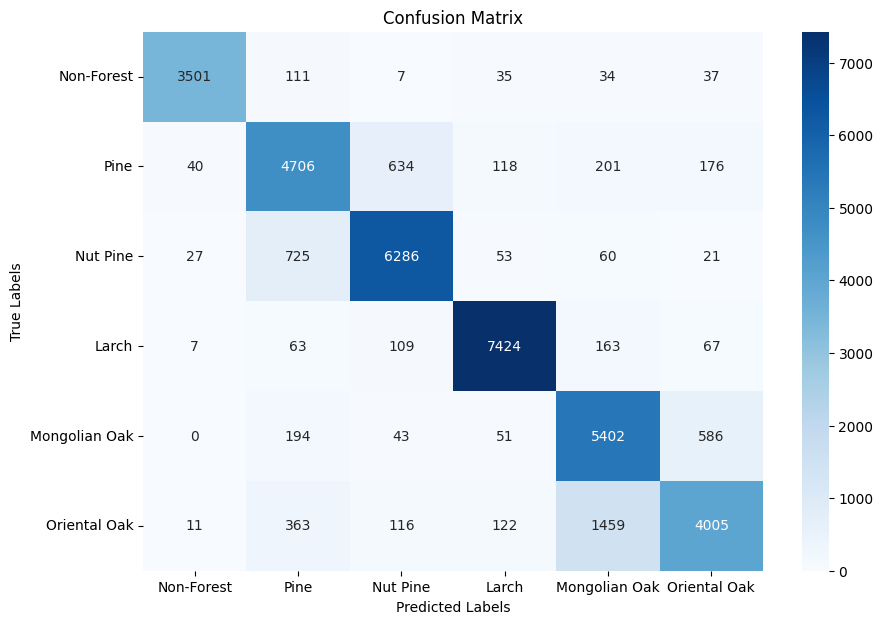

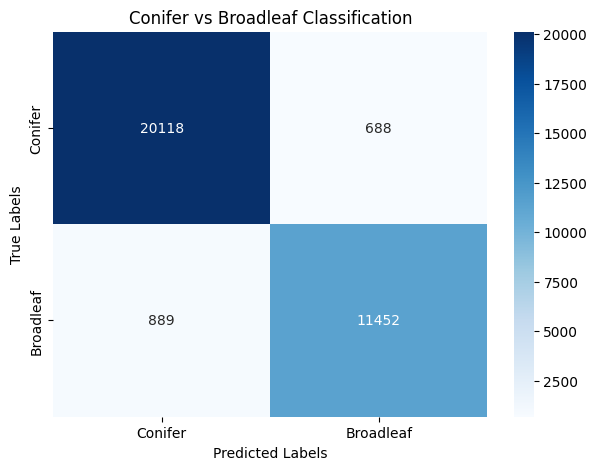

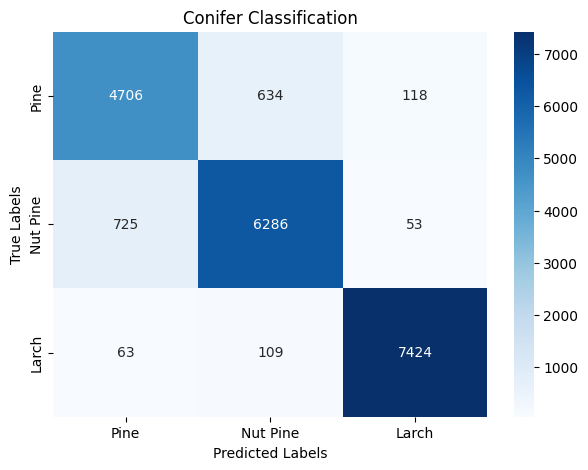

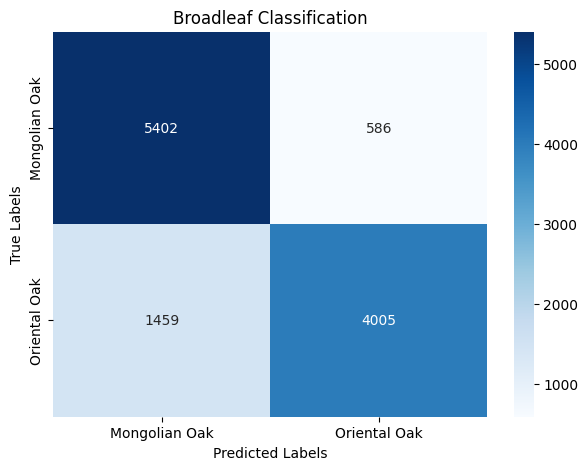

In [6]:
patch_sizes = [1, 3, 5, 7, 9, 11]
result_df_dicts = {"patch_size": [],
                   "data_type" : [],
                   "df" : []}

num_epochs = 1
os.makedirs("./checkpoints/patch_size_test", exist_ok=True) #checkpoints 저장할 dir

for patch_size in patch_sizes:
    print(patch_size)
    train_dataset, val_dataset = create_datasets(patch_size)
    train_loader, val_loader = create_dataloaders(train_dataset, val_dataset)
    
    print(f"Training with patch size: {patch_size}")

    model = ResNetLike(input_channels=48, num_classes=6).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_model_state, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, patience=100
    )
    
    torch.save(best_model_state, f"./checkpoints/patch_size_test/ResNetLike_48_{patch_size}_{num_epochs}.pth")
    model.load_state_dict(best_model_state)
    
    print("train data")
    train_df = evaluate_model_with_cm(model, train_loader, num_classes=6)
    result_df_dicts["patch_size"].append(patch_size)
    result_df_dicts["data_type"].append("train_data")
    result_df_dicts["df"].append(train_df)
    
    print("validation data")
    validation_df = evaluate_model_with_cm(model, val_loader, num_classes=6)
    result_df_dicts["patch_size"].append(patch_size)
    result_df_dicts["data_type"].append("validation")
    result_df_dicts["df"].append(validation_df)

In [7]:
# 모든 데이터를 하나의 데이터프레임으로 합치기
final_df = pd.concat([
    df.assign(patch_size=patch, data_type=dt)
    for patch, dt, df in zip(result_df_dicts["patch_size"], result_df_dicts["data_type"], result_df_dicts["df"])
], ignore_index=False)

# 인덱스를 리셋하고 정리
final_df.reset_index(inplace=True)
final_df.rename(columns={"index": "class"}, inplace=True)

# 저장
os.makedirs("./results", exist_ok=True) 
final_df.to_csv("./results/patch_size_results.csv", index=False, encoding="utf-8-sig")